# Regressão Logística

### Usando a Regressão Logística para prever a diabete.

<img src="https://i.imgur.com/bVnbwu4.jpg" />

*Cerca de um em cada sete adultos dos EUA tem diabetes agora, de acordo com os Centros para Controle e Prevenção de Doenças. Mas até 2050, essa taxa pode disparar para até um em três. Com isto em mente, isso é o que vamos fazer hoje: Aprender a usar o Aprendizado de Máquina para nos ajudar a prever o Diabetes. Vamos começar!*

Dicionário das variáveis:

- 1. preg: Número de vezes que engravidou

- 2. plas: Concentração de glicose plasmática a 2 horas em um teste oral de tolerância à glicose

- 3. press: Pressão arterial diastólica (mm Hg)

- 4. skin: Espessura da dobra da pele do tríceps (mm)

- 5. insu: Insulina sérica de 2 horas (mu U / ml)

- 6. mass: Índice de massa corporal (peso em kg / (altura em m) ^ 2)

- 7. pedi: Função de pedigree (raça) de diabetes

- 8. age: idade

- 9. class: variável target (0 or 1)

In [1]:
import matplotlib.pyplot as plt 
import seaborn as sns
import pandas as pd  
import statsmodels.api as sm  
import numpy as np  
from bokeh.plotting import figure, show, output_file
from bokeh.io import output_notebook, push_notebook, show
from ipywidgets import interact
import scipy.special
import statsmodels.formula.api as smf
from scipy import stats
%matplotlib inline

In [2]:
%time df = pd.read_csv('C:/Users/skite/OneDrive/Documentos/GitHub/Projeto_regressao_logistica/diabetes_csv .csv', sep = ',', encoding  = 'ISO-8859-1')

Wall time: 32 ms


In [3]:
df.head()

,preg,plas,pres,skin,insu,mass,pedi,age,class
0,6,148,72,35,0,33.6,0.627,50,tested_positive
1,1,85,66,29,0,26.6,0.351,31,tested_negative
2,8,183,64,0,0,23.3,0.672,32,tested_positive
3,1,89,66,23,94,28.1,0.167,21,tested_negative
4,0,137,40,35,168,43.1,2.288,33,tested_positive


### Leitura e análise dos dados:

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   preg    768 non-null    int64  
 1   plas    768 non-null    int64  
 2   pres    768 non-null    int64  
 3   skin    768 non-null    int64  
 4   insu    768 non-null    int64  
 5   mass    768 non-null    float64
 6   pedi    768 non-null    float64
 7   age     768 non-null    int64  
 8   class   768 non-null    object 
dtypes: float64(2), int64(6), object(1)
memory usage: 54.1+ KB


In [5]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
preg,768.0,3.845052,3.369578,0.000,1.00000,3.0000,6.00000,17.00
plas,768.0,120.894531,31.972618,0.000,99.00000,117.0000,140.25000,199.00
pres,768.0,69.105469,19.355807,0.000,62.00000,72.0000,80.00000,122.00
skin,768.0,20.536458,15.952218,0.000,0.00000,23.0000,32.00000,99.00
insu,768.0,79.799479,115.244002,0.000,0.00000,30.5000,127.25000,846.00
mass,768.0,31.992578,7.884160,0.000,27.30000,32.0000,36.60000,67.10
pedi,768.0,0.471876,0.331329,0.078,0.24375,0.3725,0.62625,2.42
age,768.0,33.240885,11.760232,21.000,24.00000,29.0000,41.00000,81.00


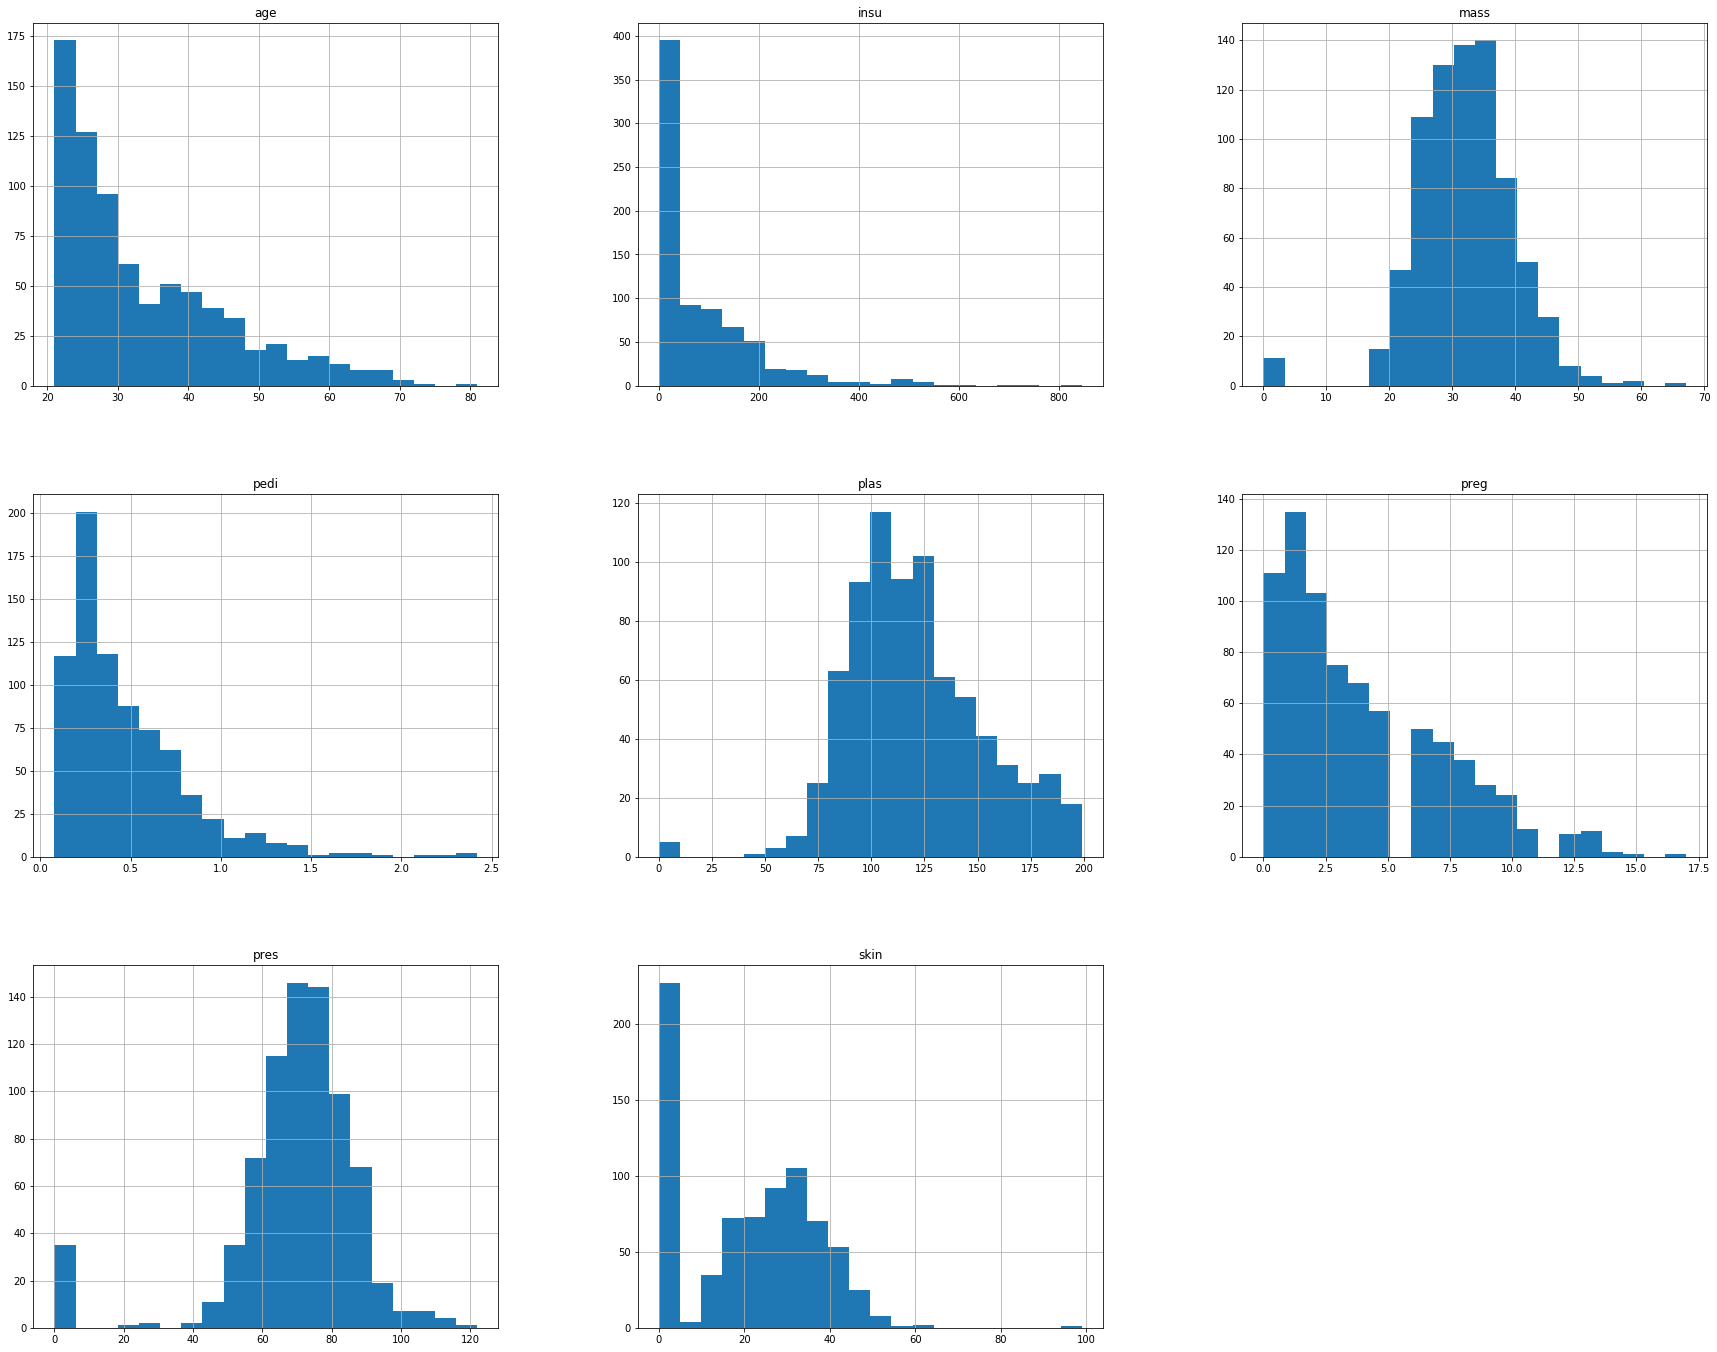

In [6]:
df.hist(figsize=(30,24),bins = 20)
plt.title("Distribuição das variáveis")
plt.show()

*Note que temo algumas variáveis que estão próxima de uma normal e outras que estão totalmente fora com muita assimetria.*

### Análisando a target:

In [7]:
df['class'].value_counts()

tested_negative    500
tested_positive    268
Name: class, dtype: int64

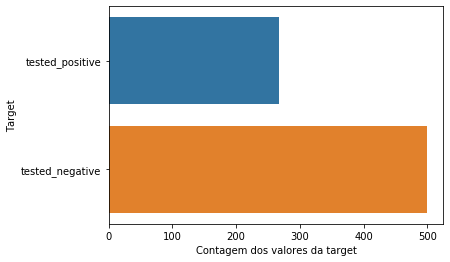

In [8]:
sns.countplot(y=df['class'] ,data=df)
plt.xlabel("Contagem dos valores da target")
plt.ylabel("Target")
plt.show()

**Vamos utilizar o pairplot para análise a targert nas demais variáveis:**

Wall time: 10.6 s


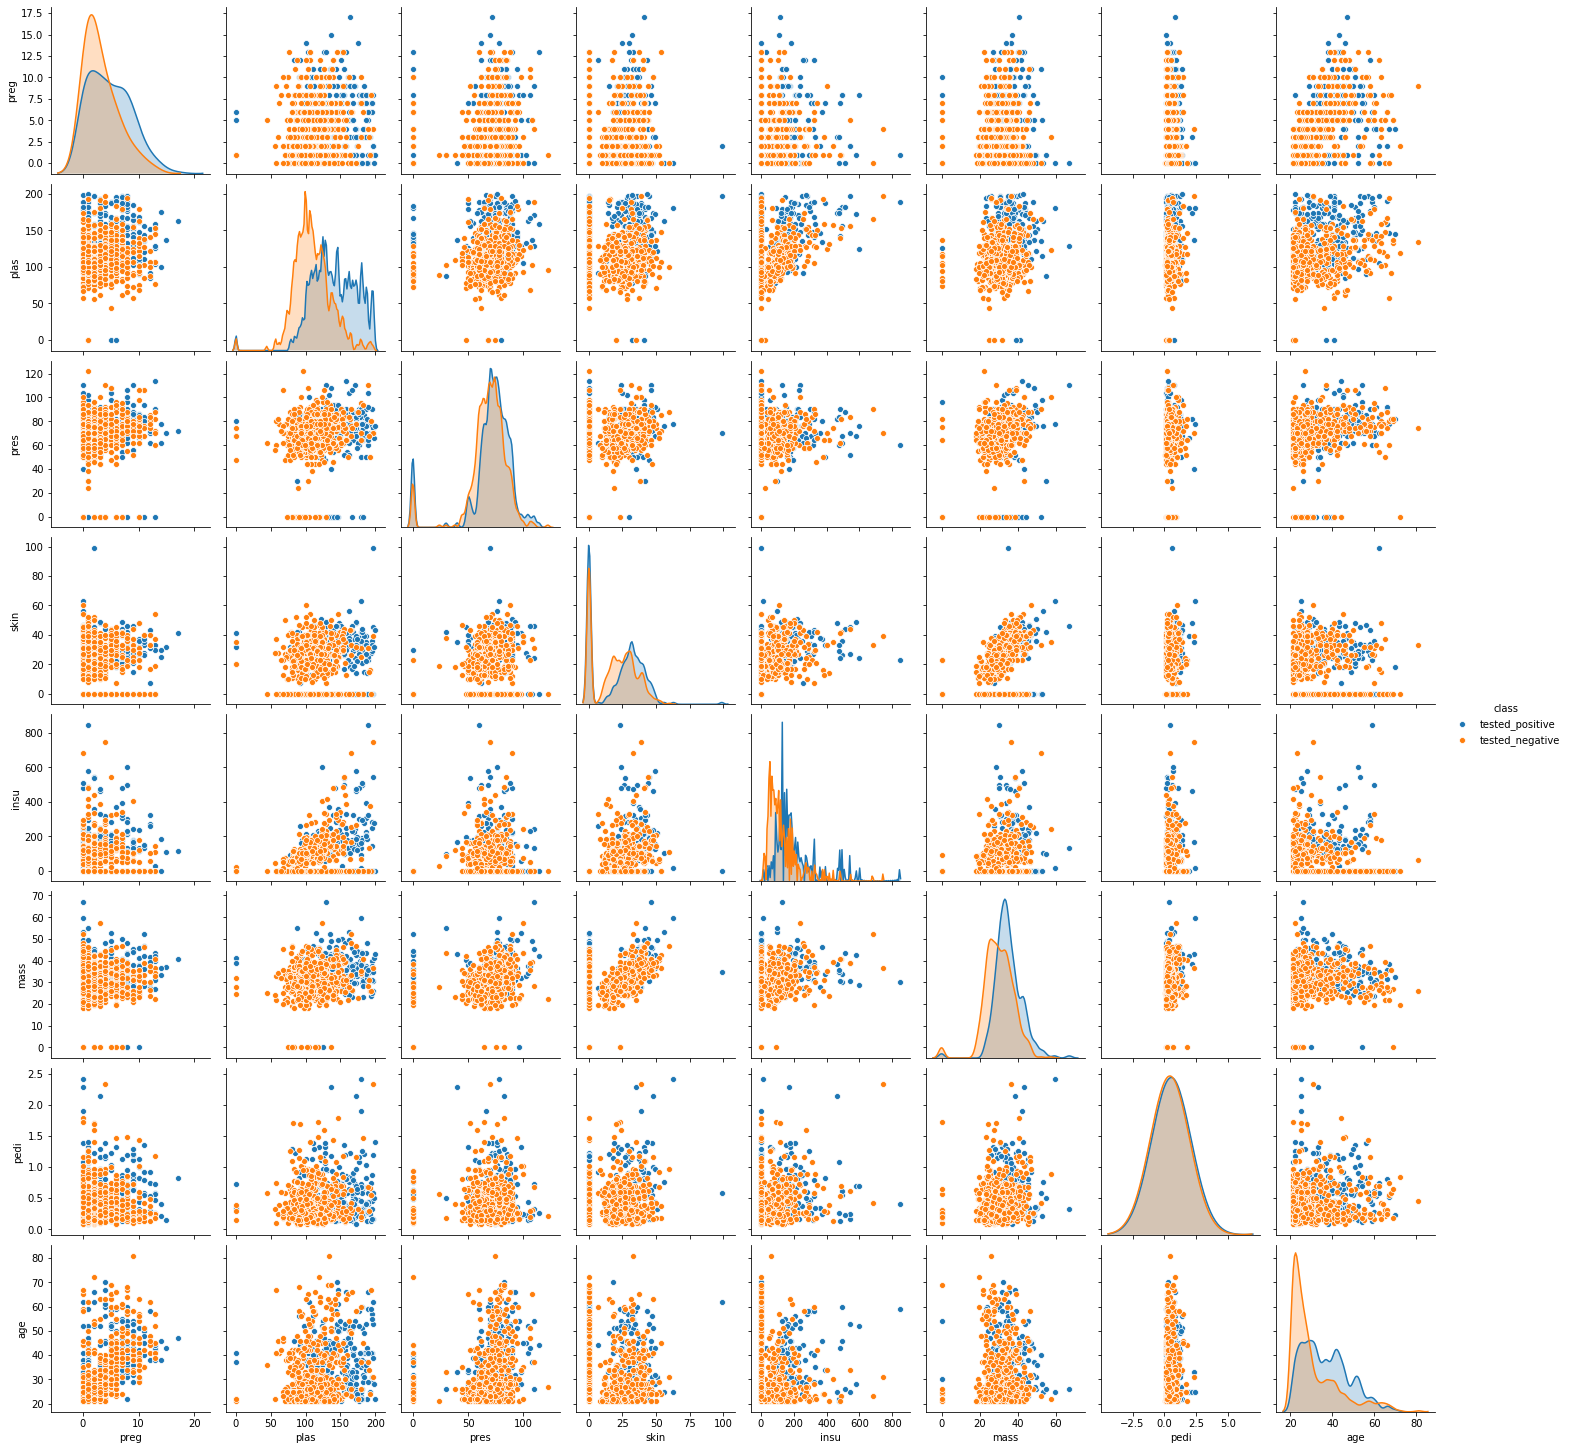

In [9]:
%time sns.pairplot(data=df,hue='class', diag_kind='kde',diag_kws={'bw':1.5})

### Vamos plotar um Heatmap de correlação entre as variáveis:

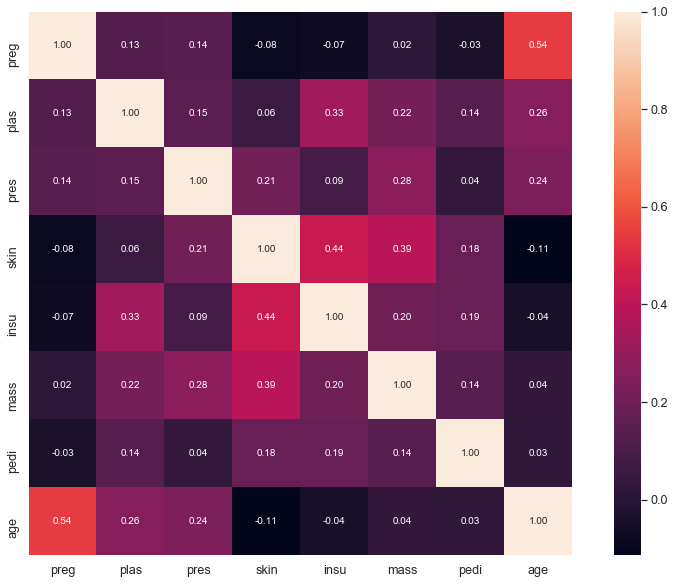

In [10]:
corrmat = df.corr()
sns.set(font_scale=1.15)
f, ax = plt.subplots(figsize=(15, 10))
hm = sns.heatmap(corrmat, 
                 cbar=True, # formatando a barra lateral de cores para o heatmap
                 annot=True, 
                 square=True, 
                 fmt='.2f', 
                 annot_kws={'size': 10}, 
                 yticklabels=corrmat.columns, 
                 xticklabels=corrmat.columns)

*Note que temos uma média correlação entre preg: Número de vezes que engravidou com a idade e skin: Espessura da dobra da pele do tríceps com as variáveis insu: Insulina sérica e mass: Índice de massa corporal.*

### Agora vamos identificar o nível de correlação das pessoas com diabete(testes_positive) com todas as variáveis do DataSet

In [11]:
df['class'].unique()

array(['tested_positive', 'tested_negative'], dtype=object)

In [12]:
set(df['class'])

{'tested_negative', 'tested_positive'}

**Vamos criar uma coluna booleana para a vairável target**

In [13]:
df['y'] = df['class'] == 'tested_positive'

In [14]:
df.head()

,preg,plas,pres,skin,insu,mass,pedi,age,class,y
0,6,148,72,35,0,33.6,0.627,50,tested_positive,True
1,1,85,66,29,0,26.6,0.351,31,tested_negative,False
2,8,183,64,0,0,23.3,0.672,32,tested_positive,True
3,1,89,66,23,94,28.1,0.167,21,tested_negative,False
4,0,137,40,35,168,43.1,2.288,33,tested_positive,True


**OK, Agora vamos plotar o heatmap novamente**

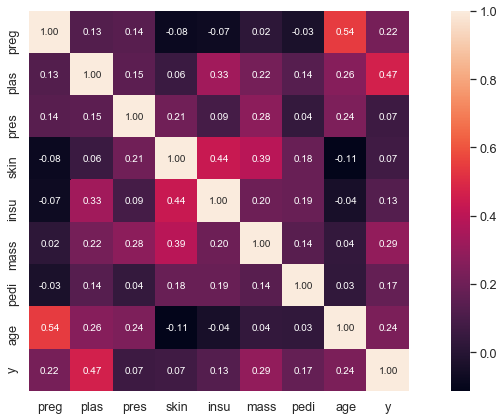

In [15]:
corrmat = df.corr()
sns.set(font_scale=1.15)
f, ax = plt.subplots(figsize=(15, 7))
hm = sns.heatmap(corrmat, 
                 cbar=True,
                 annot=True, 
                 square=True, 
                 fmt='.2f', 
                 annot_kws={'size': 10}, 
                 yticklabels=corrmat.columns, 
                 xticklabels=corrmat.columns)

*Note que agora em relação a target(y) temos uma correlação com a variável plas: Concentração de glicose plasmática.*

**Vamos fazer um rank de correlação entre as variáveis com a target**

In [16]:
df.corr().round(2)['y'].sort_values(ascending=False)

y       1.00
plas    0.47
mass    0.29
age     0.24
preg    0.22
pedi    0.17
insu    0.13
skin    0.07
pres    0.07
Name: y, dtype: float64

*Como vimos no Heatmat o plas tem uma correlação com a target, mas uma correlação média.*

**Plotando a dispersão da concentração de glicose**

*Quando plotamos a dispersão da concentração de glicose pelos casosde teste positivo em diabetes, não parece algo que possa ser representado por uma reta de tendência para representação dos dados.*

In [17]:
import bokeh

output_notebook()

Loading BokehJS ...

In [18]:
x=df['plas']
y=df['y']

fig=figure()
fig.circle(x,y)
show(fig)

**OK, agora vamos usar o OLS para estimar esse efeitos, temos um modelo linear de probabilidade.**

- pode ser usado porque a categórica tem distribuição de Bernouli e sua média é a própria probabilidade.
- Pode ser maior que 1 e menor que zero (que não faz muito sentido).

**determinando a linha de melhor ajuste (best fit line)**

In [19]:
par = np.polyfit(x, y, deg=1, full=True)
slope=par[0][0]
intercept=par[0][1]
y_predicted = [slope*i + intercept  for i in x]

**plotando a dispersão e a linha de melhor ajuste**

In [20]:
fig=figure()
fig.circle(x,y)
fig.line(x,y_predicted,color='red',legend='y='+str(round(slope,2))+'x+'+str(round(intercept,2)))
show(fig)

### Vamos rodar Regressão Linear dos testes positivos de diabetes pela concentração de glicose.

*Mudando o tipo de variável para valores inteiros.*

In [21]:
df['y'] = df['y'].astype(int)

**Rodando uma primeira regressão com a classe alvo "target" e a variável plasma**

In [22]:
function1 = 'y ~ plas'

model1 = smf.ols(formula=function1, data=df).fit()
print(model1.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.218
Model:                            OLS   Adj. R-squared:                  0.217
Method:                 Least Squares   F-statistic:                     213.2
Date:                Fri, 11 Sep 2020   Prob (F-statistic):           8.94e-43
Time:                        15:31:00   Log-Likelihood:                -426.39
No. Observations:                 768   AIC:                             856.8
Df Residuals:                     766   BIC:                             866.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.4925      0.060     -8.262      0.0

**Vamos a análise do resultado da regressão linear:**

- R quadrado: temos uma taxa de explicabilidade de 0.218 ou seja 21% meio baixo no decorrer do projeto vamos tentar melhor esse valor.
- R Quadrado ajustado: R Quadrado com o desconto do número de graus de liberdade uma pequena queda de 0.218 para 0.217
- F-Statistic (Multicolinearidade):  Em geral, o valor de F-Statistic deve ser maior que 4 e sua probabilidade ser 0 então temos 213.2.
- Log_likelihood: Para que o modelo se demontre semelhante, devemos ter um resultado negativo.
- AIC: Para um bom ajuste, o resultado deve ser um número bem próximo a zero, logo temos um AIC muito alto 856.8.
- BIC: Quanto menor for seu valor, melhor é o ajuste matemático para minimização dos erros quadráticos, temos um lavor muito alto para BIC 866.1
- Omnibus: Seu teste de probabilidade deve tender a zero (distribuição normal dos erros), prefeito conseguimos um valor de 0.
- Durbin-Watson (Endogeneidade):Dessa forma, o valor esperado para o teste Durbin-Watson deve estar próximo de 2 para indicar erros aleatórios independentes, ficou próximo temos 1.997
- Jarque-Bera (Distribuição-Normal dos Erros): seu teste de probabilidade deve tender a zero (distribuição normal dos erros), ficou muito fora 53.855.
- Condition No. (Multicolinearidade):  Deve ter valores entre 10 e 30, também ficou com um valor muito alto 489.

### Vamos rodar outra Regressão Linear só que dessa vez com todas as variáveis do DataSet.

In [23]:
list(df)

['preg', 'plas', 'pres', 'skin', 'insu', 'mass', 'pedi', 'age', 'class', 'y']

**Rodando uma regressão linear com todas as variáveis**

In [24]:
function2 = 'y ~ preg + plas + pres + skin + insu + mass + pedi + age'

model2 = smf.ols(function2, df).fit()
print(model2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.303
Model:                            OLS   Adj. R-squared:                  0.296
Method:                 Least Squares   F-statistic:                     41.29
Date:                Fri, 11 Sep 2020   Prob (F-statistic):           7.36e-55
Time:                        15:49:49   Log-Likelihood:                -381.91
No. Observations:                 768   AIC:                             781.8
Df Residuals:                     759   BIC:                             823.6
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.8539      0.085     -9.989      0.0

**Vamos a análise do resultado da nova regressão linear:**

- R quadrado: temos uma taxa de explicabilidade de 0.303 ou seja 30% meio baixo no decorrer do projeto vamos tentar melhor esse valor.
- R Quadrado ajustado: R Quadrado com o desconto do número de graus de liberdade uma pequena queda de 0.303 para 0.296
- F-Statistic (Multicolinearidade):  Em geral, o valor de F-Statistic deve ser maior que 4 e sua probabilidade ser 0 então consegimos baixa muito em relação a regressão anterior para 41.29, mas mesmo assim ficou fora do esperado.
- Log_likelihood: Para que o modelo se demontre semelhante, devemos ter um resultado negativo.
- AIC: Para um bom ajuste, o resultado deve ser um número bem próximo a zero, logo temos um AIC muito alto 781.8.
- BIC: Quanto menor for seu valor, melhor é o ajuste matemático para minimização dos erros quadráticos, temos um lavor muito alto para BIC 823.6
- Omnibus: Seu teste de probabilidade deve tender a zero (distribuição normal dos erros), tivemos um aumento significativo do omnibus para 41.539.
- Durbin-Watson (Endogeneidade):Dessa forma, o valor esperado para o teste Durbin-Watson deve estar próximo de 2 para indicar erros aleatórios independentes, ficou próximo temos 1.982
- Jarque-Bera (Distribuição-Normal dos Erros): seu teste de probabilidade deve tender a zero (distribuição normal dos erros), tivemos uma pequena redução para 31.183.
- Condition No. (Multicolinearidade):  Deve ter valores entre 10 e 30, também ficou com um valor muito alto 1000.

*Podemos ajustar as variáveis para melhor os parametros da regressão linear, mas nao vamos conseguir grander alterações então tentarei rodar uma regressão logística.*

### Rodando a Regressão Logística

**Rodando uma regressão logística com todas as vairáveis do dataset**

In [26]:
logit = smf.logit(formula=function2, data=df).fit()
print(logit.summary())

print ("Odds Ratios")
print ("======================")
print (np.exp(logit.params))

Optimization terminated successfully.
         Current function value: 0.470993
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                  768
Model:                          Logit   Df Residuals:                      759
Method:                           MLE   Df Model:                            8
Date:                Fri, 11 Sep 2020   Pseudo R-squ.:                  0.2718
Time:                        16:46:33   Log-Likelihood:                -361.72
converged:                       True   LL-Null:                       -496.74
Covariance Type:            nonrobust   LLR p-value:                 9.652e-54
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -8.4047      0.717    -11.728      0.000      -9.809      -7.000
preg           0.1232      0.

**Interpretando Odds Ratio (Betas da Regressão Logística)**

- preg: A cada uma gravidez a mais das mulheres desta observação, a chance de terem a condição de diabetes aumenta em (1.131 - 1.00) * 100% = 13.1%
- plas: A cada um ponto a mais na concentação de glicose no plasma das mulheres desta observação, a chance de terem a condição de diabetes aumenta em (1.036 - 1.00) * 100% = 3.6%
- pres: A cada um ponto a mais na pressão sanguínea diastólica das mulheres desta observação, a chance de terem a condição de diabetes diminui em (0.987 - 1.00) * 100% = -1.3%
- skin: A cada um ponto a mais na espessura da pele do tríceps das mulheres desta observação, a chance de terem a condição de diabetes aumenta em (1.001 - 1.00) * 100% = 0.1%
- insu: A cada um ponto a mais na insulina sérica das mulheres desta observação, a chance de terem a condição de diabetes diminui em (0.999 - 1.00) * 100% = -1.0%
- mass: A cada um ponto a mais no índice de massa corpórea das mulheres desta observação, a chance de terem a condição de diabetes aumenta em (1.094 - 1.00) * 100% = 9.4%
- pedi: A cada um ponto a mais na predisposição genética das mulheres desta observação, a chance de terem a condição de diabetes aumenta em (2.573 - 1.00) * 100% = 157.3%
- age: A cada ano a mais de idade das mulheres desta observação, a chance de terem a condição de diabetes aumenta em (1.015 - 1.00) * 100% = 1.5%

**Vamos falar brevimente sobre o Pseudo R_Squared**

*Ao analisar dados com uma regressão logística, não existe uma estatística equivalente ao quadrado-R. As estimativas do modelo a partir de uma regressão logística são estimativas de probabilidade máxima alcançadas por um processo iterativo. Eles não são calculados para minimizar a variação, portanto, a abordagem OLS para ajuste de qualidade não se aplica. No entanto, para avaliar a adequação dos modelos logísticos, vários pseudo-quadrados-R foram desenvolvidos. Esses são os quadrantes R “pseudo” porque se parecem com o quadrado R no sentido de que estão em uma escala semelhante, variando de 0 a 1 (embora alguns pseudo quadrados R nunca alcancem 0 ou 1), com valores mais altos indicando melhor modelo se encaixam, mas não podem ser interpretados como se fosse interpretado um quadrado R de OLS e diferentes pseudo-quadrados R podem chegar a valores muito diferentes. Observe que a maioria dos pacotes de software relata o logaritmo natural da probabilidade devido a problemas de precisão de ponto flutuante que surgem mais comumente com probabilidades brutas.*

*Embora os pseudo-quadrados-R não possam ser interpretados independentemente ou comparados entre conjuntos de dados, eles são válidos e úteis na avaliação de vários modelos que prevêem o mesmo resultado no mesmo conjunto de dados. Em outras palavras, uma estatística pseudo-R ao quadrado sem contexto tem pouco significado. Um pseudo-quadrado ao quadrado apenas tem significado quando comparado a outro pseudo-quadrado do mesmo tipo, nos mesmos dados, prevendo o mesmo resultado. Nessa situação, o maior pseudo-quadrado R indica qual modelo prediz melhor o resultado.*

crédito:https://stats.idre.ucla.edu/other/mult-pkg/faq/general/faq-what-are-pseudo-r-squareds/

### Vamos fazer cálculo do valor predito para que o indivíduo tenha diabetes de acordo com a Regressão Logistica.

In [30]:
df.head()

,preg,plas,pres,skin,insu,mass,pedi,age,class,y
0,6,148,72,35,0,33.6,0.627,50,tested_positive,1
1,1,85,66,29,0,26.6,0.351,31,tested_negative,0
2,8,183,64,0,0,23.3,0.672,32,tested_positive,1
3,1,89,66,23,94,28.1,0.167,21,tested_negative,0
4,0,137,40,35,168,43.1,2.288,33,tested_positive,1


In [31]:
logit.conf_int()

,0,1
Intercept,-9.809277,-7.000115
preg,0.060311,0.186053
plas,0.027895,0.042433
pres,-0.023553,-0.003038
skin,-0.012904,0.014141
insu,-0.002958,0.000575
mass,0.060130,0.119272
pedi,0.358861,1.531498
age,-0.003427,0.033165


**Verificando os valores de BETA da regresão logística**

In [33]:
logit.conf_int().mean(axis=1)

Intercept   -8.404696
preg         0.123182
plas         0.035164
pres        -0.013296
skin         0.000619
insu        -0.001192
mass         0.089701
pedi         0.945180
age          0.014869
dtype: float64

In [34]:
logit.params

Intercept   -8.404696
preg         0.123182
plas         0.035164
pres        -0.013296
skin         0.000619
insu        -0.001192
mass         0.089701
pedi         0.945180
age          0.014869
dtype: float64

**Verificando o código para cada posição dos valores da primeira observação**

In [35]:
df.iloc[0, 0]

6

**calculando a soma dos valores para a primeira observação**

In [37]:
soma = 0

for index, beta in enumerate(list(logit.params)):
    if index == 0:
        soma = soma + beta
    else:
        betax = beta * df.iloc[0, index-1]
        print(df.iloc[0, index-1], beta, betax)
        soma += betax

print(soma)

6 0.12318229835243938 0.7390937901146363
148 0.035163714606856654 5.204229761814784
72 -0.01329554690430616 -0.9572793771100435
35 0.0006189643648757494 0.021663752770651228
0 -0.0011916989841622321 -0.0
33.6 0.08970097003094657 3.013952593039805
0.627 0.9451797406211299 0.5926276973694484
50 0.014869004744469482 0.7434502372234741
0.953042088308615


- agora vamos aplicando o valor de soma na fórmula da Função Logit (método raiz)
- cálculo do valor de predição para a primeira observação do DataSet

In [41]:
logit.predict()[0]

0.7217265548405951

**Criando uma coluna no DataFrame com os valores preditos**

In [42]:
df['yhat'] = logit.predict()

**Plotando um histograma com os valores preditos**

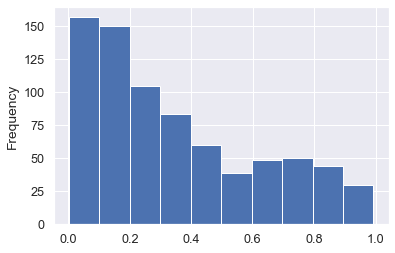

In [44]:
df['yhat'].plot.hist()

**Curva densdade de probabilidade dos valores preditos**

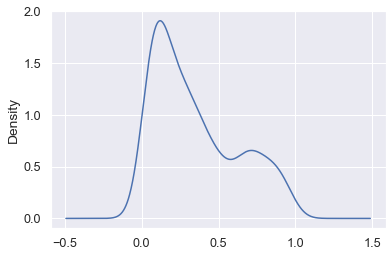

In [45]:
%matplotlib inline
df['yhat'].plot.kde()

**Verificando a porcentagem de valores da variável alvo**

In [46]:
df['class'].value_counts(1)

tested_negative    0.651042
tested_positive    0.348958
Name: class, dtype: float64

### OK, agora vamos analisando probabilidade condicional

In [48]:
df.head()

,preg,plas,pres,skin,insu,mass,pedi,age,class,y,yhat
0,6,148,72,35,0,33.6,0.627,50,tested_positive,1,0.721727
1,1,85,66,29,0,26.6,0.351,31,tested_negative,0,0.048642
2,8,183,64,0,0,23.3,0.672,32,tested_positive,1,0.796702
3,1,89,66,23,94,28.1,0.167,21,tested_negative,0,0.041625
4,0,137,40,35,168,43.1,2.288,33,tested_positive,1,0.902184


**Definindo um limite THRESOLD de 0.5 para a variável alvo**

In [51]:
df['yresult'] = 0

threshold = 0.5 # <---------------------- limite de corte (decisão de negócios)

for (i, p) in enumerate(df['yhat']):
    if p > threshold:
        df['yresult'][i] = 1

C:\Users\skite\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [53]:
df.head(20)

,preg,plas,pres,skin,insu,mass,pedi,age,class,y,yhat,yresult
0,6,148,72,35,0,33.6,0.627,50,tested_positive,1,0.721727,1
1,1,85,66,29,0,26.6,0.351,31,tested_negative,0,0.048642,0
2,8,183,64,0,0,23.3,0.672,32,tested_positive,1,0.796702,1
3,1,89,66,23,94,28.1,0.167,21,tested_negative,0,0.041625,0
4,0,137,40,35,168,43.1,2.288,33,tested_positive,1,0.902184,1
5,5,116,74,0,0,25.6,0.201,30,tested_negative,0,0.146632,0
6,3,78,50,32,88,31.0,0.248,26,tested_positive,1,0.066578,0
7,10,115,0,0,0,35.3,0.134,29,tested_negative,0,0.644570,1
8,2,197,70,45,543,30.5,0.158,53,tested_positive,1,0.709358,1
9,8,125,96,0,0,0.0,0.232,54,tested_positive,1,0.036336,0


**Fazendo uma contagem para os valores criados**

In [54]:
df['yresult'].value_counts()

0    557
1    211
Name: yresult, dtype: int64

**Comparando com os valores reais**

In [55]:
df['y'].value_counts()

0    500
1    268
Name: y, dtype: int64

### Matriz de Confusão

In [56]:
from sklearn.metrics import confusion_matrix

import warnings
warnings.filterwarnings("ignore")

result_matrix = confusion_matrix(y_true=df.y, y_pred=df.yresult)
result_matrix

array([[445,  55],
       [112, 156]], dtype=int64)

**ok vamos atribuir os valores da matriz às variáveis**
- tp: True Positive
- fp: False Positive
- fn: False Negative
- tn: True Negative

In [57]:
tn, fp, fn, tp = confusion_matrix(df.y, df.yresult).ravel()
tn, fp, fn, tp

(445, 55, 112, 156)

**Vamos verificar a precisão**

In [58]:
precision = tp / (tp+fp)
precision

0.7393364928909952

**Agora vamos cálcular a Sensiblidade**
- TPR: True Positive rate

In [59]:
recall = tp / (tp+fn)
recall

0.582089552238806

In [60]:
f1_score = 2*(precision*recall)/(precision+recall)
f1_score

0.651356993736952

In [61]:
from sklearn.metrics import classification_report
print(classification_report(y_true=df.y, y_pred=df.yresult))

              precision    recall  f1-score   support

           0       0.80      0.89      0.84       500
           1       0.74      0.58      0.65       268

    accuracy                           0.78       768
   macro avg       0.77      0.74      0.75       768
weighted avg       0.78      0.78      0.78       768



**Tivemos um acurácia 78% para o nosso modelo**